# Final Assigment in KI anwendung
## Autor : Manuel Caipo

```to run this code please put the file "utils.py","C64_Ziffern_Daten.pkl" and the folder "images"(with my handwriting) in the same folder of this notebook ```

In [1]:
#Libraries
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
import time
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
from loguru import logger
from torch.profiler import profile, record_function, ProfilerActivity
import pickle
from torchviz import make_dot
from utils import load_mnist_images, display_image,inspect_batch,show_image_with_label,visualize_transformed_image
from utils import load_and_evaluate,display_predictions_grid
from utils import load_and_transform_images,update_pkl_file
from utils import live_number_recognition
from torch.utils.tensorboard import SummaryWriter 
import random

import random
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pickle
from PIL import Image
import numpy as np
import cv2

Die Daten sind vom Typ: <class 'list'> und enthalten 10000 Datenelemente.

Jedes Datenelement ist vom Typ: <class 'tuple'> und hat 2 Elemente:
 - Bild vom Typ: <class 'torch.Tensor'> mit der Größe: torch.Size([8, 8])
 - Label vom Typ: <class 'int'>


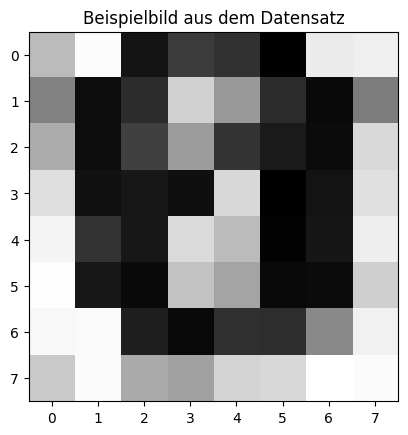

In [2]:
# Reading Data and describing
with open('C64_Ziffern_Daten.pkl', 'rb') as f: data = pickle.load(f)

print('Die Daten sind vom Typ:', type(data), 'und enthalten', len(data),'Datenelemente.\n')
print('Jedes Datenelement ist vom Typ:', type(data[0]), 'und hat', len(data[0]), 'Elemente:')
print(' - Bild vom Typ:', type(data[0][0]), 'mit der Größe:', data[0][0]. shape)
print(' - Label vom Typ:', type(data[0][1])) 
plt.title('Beispielbild aus dem Datensatz') 
plt.imshow(data[0][0], cmap='Grays')

# Data Transformation

To use PyTorch functions, images must meet specific format requirements. The original data consists of **tuples** with `torch.Tensor` images of size `(8,8)`, but PyTorch requires tensors in the format `(C, H, W)`, where **C = channels, H = height, W = width**. Normalization is also necessary to improve model stability.

**PIL (Python Imaging Library)** is used to load and manipulate images in Python. PyTorch uses **Pillow** to convert images from `numpy.ndarray` or `torch.Tensor` into a manageable format before applying transformations.

#### What does `CustomTensorDataset` do?

The `CustomTensorDataset` class adapts the data for use in PyTorch:

- **Stores the data** as tuples `(image, label)`.
- **Converts images** to PIL if they are in `numpy.ndarray` or `torch.Tensor`.
- **Applies transformations** (resizing, normalization, etc.).
- **Returns** the transformed image and its label.

This ensures that `(8,8)` images are resized and formatted correctly for compatibility with PyTorch models, such as MNIST or aditinal images.


In [3]:
# Transformations for training and testing
transform_train = transforms.Compose([
    transforms.Resize((28, 28)),              # Redimensiona a 28x28
    transforms.RandomRotation(10),           # Rotación aleatoria
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Desplazamiento aleatorio
    transforms.ToTensor(),                   # Convierte a tensor
    transforms.Normalize((0.5,), (0.5,))     # Normaliza
])

transform_test = transforms.Compose([
    transforms.Resize((28, 28)),             # Redimensiona a 28x28
    transforms.ToTensor(),                   # Convierte a tensor
    transforms.Normalize((0.5,), (0.5,))     # Normaliza
])


# Custom dataset class
class CustomTensorDataset(Dataset):
    def __init__(self, tensors, transform=None):
        self.tensors = tensors
        self.transform = transform

    def __len__(self):
        return len(self.tensors)

    def __getitem__(self, idx):
        image, label = self.tensors[idx]
        # Convert image if necessary
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        elif torch.is_tensor(image):
            image = transforms.ToPILImage()(image)
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        return image, label

# Load dataset
with open('C64_Ziffern_Daten.pkl', 'rb') as f:
    data = pickle.load(f)

# Check dataset content
print(f"Data type: {type(data)}")
print(f"First element example: {data[0]}")

# Split the dataset
num_train_data_pk = round(len(data) * 0.8)
train_data_pk, test_data_pk = torch.utils.data.random_split(data, [num_train_data_pk, len(data) - num_train_data_pk])

# Create transformed datasets
train_set_pk = CustomTensorDataset(train_data_pk, transform=transform_train)
test_set_pk = CustomTensorDataset(test_data_pk, transform=transform_test)

# Create data loaders
batch_size_pk = 16
trainloader_pk = DataLoader(train_set_pk, batch_size=batch_size_pk, shuffle=True)
testloader_pk = DataLoader(test_set_pk, batch_size=batch_size_pk, shuffle=True)

# Verify the data loader
for images, labels in trainloader_pk:
    print(f"Image batch size: {images.shape}")
    print(f"Labels: {labels}")
    #print(images)  # Muestra el tensor de 28x28
    break

Data type: <class 'list'>
First element example: (tensor([[0.3928, 0.0469, 0.9262, 0.8127, 0.8382, 0.9960, 0.1674, 0.1467],
        [0.5768, 0.9534, 0.8520, 0.2976, 0.4989, 0.8527, 0.9619, 0.5989],
        [0.4381, 0.9512, 0.8014, 0.4884, 0.8352, 0.9078, 0.9555, 0.2604],
        [0.2353, 0.9352, 0.9175, 0.9449, 0.2654, 0.9940, 0.9295, 0.2242],
        [0.1063, 0.8323, 0.9187, 0.2577, 0.3913, 0.9843, 0.9198, 0.1516],
        [0.0361, 0.9163, 0.9586, 0.3610, 0.4630, 0.9646, 0.9556, 0.3049],
        [0.0717, 0.0577, 0.8920, 0.9642, 0.8419, 0.8484, 0.5507, 0.1284],
        [0.3309, 0.0507, 0.4447, 0.4702, 0.2834, 0.2680, 0.0203, 0.0480]]), 0)
Image batch size: torch.Size([16, 1, 28, 28])
Labels: tensor([4, 5, 4, 5, 5, 7, 0, 6, 4, 9, 6, 7, 4, 7, 9, 9])


### Visualizing data Transformed

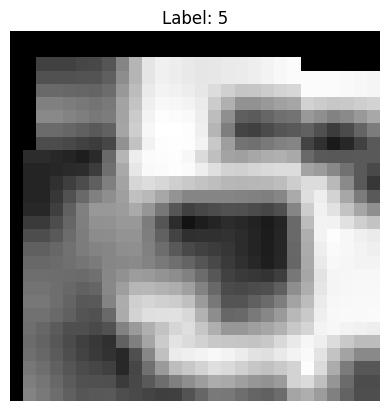

In [4]:
visualize_transformed_image(trainloader_pk, batch_number=0, image_index=3)

# Definition Neural Network

### Summary of Steps in `ImprovedNet`

`Padding = Reduce total size(ex.28x28->14x14)
Stride = Lenght of step(messured on pixels)
Kernel = Size of the filter(matrix)`

1. **Conv1 (`Conv2d(1, 16, kernel_size=3, stride=1, padding=1)`)**  
   - Applies 16 filters **3x3**, `stride=1`, `padding=1`  
   - **Output:** `16x28x28` (size preserved due to `padding=1`)

2. **Conv2 (`Conv2d(16, 32, kernel_size=3, stride=1, padding=1)`)**  
   - Applies 32 filters **3x3**, `stride=1`, `padding=1`  
   - **Output:** `32x28x28`

3. **Max Pooling (`MaxPool2d(kernel_size=2, stride=2)`)**  
   - Reduces size by half, taking max values from **2x2** blocks, `stride=2`  
   - **Output:** `32x14x14`

4. **Flatten (`torch.flatten(x, 1)`)**  
   - Converts `32x14x14` into a `6272`-element vector

5. **Fully Connected Layers (`fc1`, `fc2`, `fc3`)**  
   - `fc1`: `6272 → 128`, ReLU + Dropout  
   - `fc2`: `128 → 64`, ReLU + Dropout  
   - `fc3`: `64 → 10`, final output with logits


In [5]:
class ImprovedNet(nn.Module):
    def __init__(self):
        super(ImprovedNet, self).__init__()
        # Convolutional layers with fewer filters
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling

        # Calculate flattened size dynamically
        self._flattened_size = self._get_flattened_size()

        # Fully connected layers with reduced sizes
        self.fc1 = nn.Linear(self._flattened_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

        # Dropout with reduced probability
        self.dropout = nn.Dropout(0.3)

    def _get_flattened_size(self):
        # Use a dummy tensor to compute the size after the convolutional layers
        dummy_input = torch.zeros(1, 1, 28, 28)  # MNIST input size: 1 channel, 28x28 pixels
        x = F.relu(self.conv1(dummy_input))
        x = self.pool(F.relu(self.conv2(x)))
        return x.numel()  # Flattened size

    def forward(self, x):
        # Convolutional layers with ReLU
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the tensor
        x = torch.flatten(x, 1)

        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # Output layer (no activation, logits)
        x = self.fc3(x)
        return x

## Instance and visualization NeuralNetwork

In [6]:
# Create an instance of the model
model_pk = ImprovedNet()
model_pk.eval()

ImprovedNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

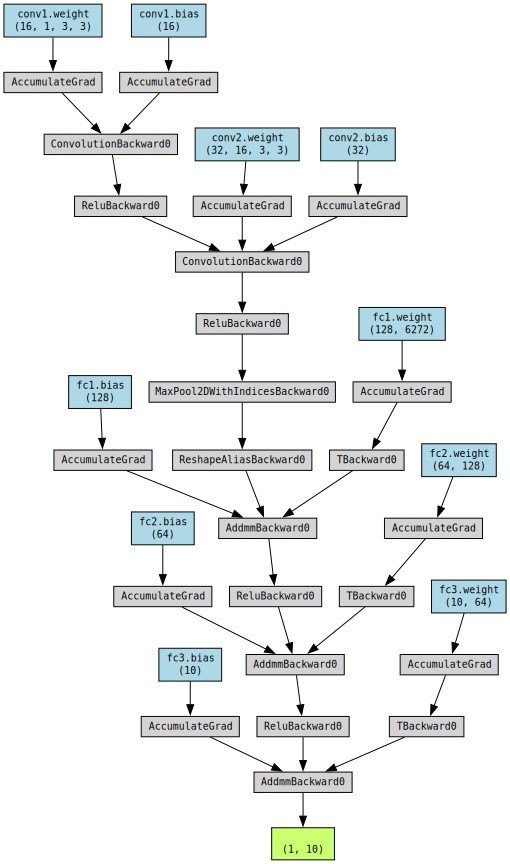

In [7]:
# Create a dummy input for visualization
dummy_input = torch.randn(1, 1, 28, 28) 

# Create the visualization graph
vis_graph = make_dot(model_pk(dummy_input), params=dict(list(model_pk.named_parameters())))

# Display the visualization (you might need to install Graphviz)
vis_graph

## Model Training

In [8]:

learning_rate=0.001
epochs=4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_pk = model_pk.to(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pk.parameters(), lr=learning_rate)

#The optimizer can influence the speed and stability of training. 
# Instead of SGD, you can use Adam, which automatically adjusts the
#  learning rates for each parameter:


In [9]:
def train_and_evaluate(trainloader, testloader, model, optimizer, criterion, epochs, device):
    """
    Train the model and evaluate its accuracy on the test dataset.

    Parameters:
    - trainloader: DataLoader for the training dataset.
    - testloader: DataLoader for the testing dataset.
    - model: The PyTorch model to train.
    - optimizer: The optimizer used for training.
    - criterion: The loss function.
    - epochs: Number of epochs to train.
    - device: The device to use ('cpu' or 'cuda').
    """
    model.to(device)

    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        # Training over each batch
        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        # Calculate accuracy after each epoch
        model.eval()  # Set model to evaluation mode
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)  # Get predicted labels
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Epoch: {epoch + 1}/{epochs}, Loss: {epoch_loss / len(trainloader):.6f}, Accuracy: {accuracy:.2f}%')



In [10]:
train_and_evaluate(
    trainloader=trainloader_pk,
    testloader=testloader_pk,
    model=model_pk,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs,
    device=device
)

Epoch: 1/4, Loss: 0.908101, Accuracy: 99.25%
Epoch: 2/4, Loss: 0.245044, Accuracy: 99.80%
Epoch: 3/4, Loss: 0.142068, Accuracy: 99.70%
Epoch: 4/4, Loss: 0.118310, Accuracy: 100.00%


## Saving Model weights

In [11]:
torch.save(model_pk.state_dict(), "improved_net_weights_pk.pth")
logger.info("Model weights with pk Data saved successfully!")

2025-03-28 13:30:27.470 | INFO     | __main__:<module>:2 - Model weights with pk Data saved successfully!


## Loading weights

In [12]:
# Load the saved weights into the model
model_pk.load_state_dict(torch.load("improved_net_weights.pth"))
print("Model weights loaded successfully!")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_pk = model_pk.to(device=device)
# Set the model to evaluation mode for inference

Model weights loaded successfully!


### Training with my handwriting and adding it to the pickle file

In [13]:
images_data = load_and_transform_images()
update_pkl_file(images_data, output_file="C64_Ziffern_plus_myhandwriting.pkl")


Total tuples after update: 20000
File saved as: C64_Ziffern_plus_myhandwriting.pkl


20000

Displaying some of the newly added images:


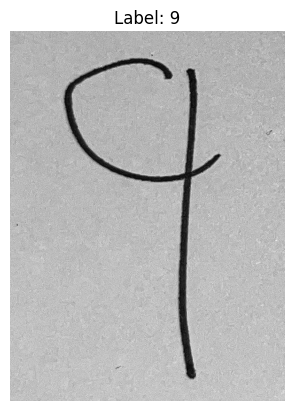

Data type: <class 'list'>
First element example: (tensor([[0.3928, 0.0469, 0.9262, 0.8127, 0.8382, 0.9960, 0.1674, 0.1467],
        [0.5768, 0.9534, 0.8520, 0.2976, 0.4989, 0.8527, 0.9619, 0.5989],
        [0.4381, 0.9512, 0.8014, 0.4884, 0.8352, 0.9078, 0.9555, 0.2604],
        [0.2353, 0.9352, 0.9175, 0.9449, 0.2654, 0.9940, 0.9295, 0.2242],
        [0.1063, 0.8323, 0.9187, 0.2577, 0.3913, 0.9843, 0.9198, 0.1516],
        [0.0361, 0.9163, 0.9586, 0.3610, 0.4630, 0.9646, 0.9556, 0.3049],
        [0.0717, 0.0577, 0.8920, 0.9642, 0.8419, 0.8484, 0.5507, 0.1284],
        [0.3309, 0.0507, 0.4447, 0.4702, 0.2834, 0.2680, 0.0203, 0.0480]]), 0)
Image batch size: torch.Size([16, 1, 28, 28])
Labels: tensor([9, 4, 7, 4, 8, 7, 9, 0, 3, 9, 3, 7, 4, 2, 9, 6])


In [14]:
# Load dataset
with open('C64_Ziffern_plus_myhandwriting.pkl', 'rb') as f:
    data = pickle.load(f)
    
def show_tensor_image(tensor, label):
    """ Muestra una imagen de tensor con su etiqueta """
    plt.imshow(tensor.numpy(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

# Mostrar las últimas 5 imágenes agregadas
print("Displaying some of the newly added images:")
for i in range(-1, 0):  # Últimas 5 imágenes
    show_tensor_image(data[i][0], data[i][1])  # (imagen, lab

# Check dataset content
print(f"Data type: {type(data)}")
print(f"First element example: {data[0]}")

# Split the dataset
num_train_data_ph = round(len(data) * 0.8)
train_data_pk, test_data_ph = torch.utils.data.random_split(data, [num_train_data_pk, len(data) - num_train_data_pk])

# Create transformed datasets
train_set_ph = CustomTensorDataset(train_data_pk, transform=transform_train)
test_set_ph = CustomTensorDataset(test_data_pk, transform=transform_test)

# Create data loaders
batch_size_ph = 16
trainloader_ph = DataLoader(train_set_pk, batch_size=batch_size_pk, shuffle=True)
testloader_ph = DataLoader(test_set_pk, batch_size=batch_size_pk, shuffle=True)

# Verify the data loader
for images, labels in trainloader_pk:
    print(f"Image batch size: {images.shape}")
    print(f"Labels: {labels}")
    #print(images)  # Muestra el tensor de 28x28
    break

In [15]:
# Create an instance of the model from cero with my handwriting
model_ph = ImprovedNet()
model_ph.eval()
learning_rate=0.001
epochs=4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_pk = model_pk.to(device=device)
batch_size_ph = 16
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ph.parameters(), lr=learning_rate)
train_and_evaluate(
    trainloader=trainloader_ph,
    testloader=testloader_ph,
    model=model_ph,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs,
    device=device
)

Epoch: 1/4, Loss: 0.796589, Accuracy: 99.30%
Epoch: 2/4, Loss: 0.198114, Accuracy: 99.65%
Epoch: 3/4, Loss: 0.106715, Accuracy: 99.95%
Epoch: 4/4, Loss: 0.089674, Accuracy: 100.00%


## Saving Model weights with my handwriting

In [16]:
torch.save(model_ph.state_dict(), "improved_net_weights_ph.pth")
logger.info("Model weights with ph Data saved successfully!")

2025-03-28 13:31:09.673 | INFO     | __main__:<module>:2 - Model weights with ph Data saved successfully!


## Loading Model wieghts with my handwriting

In [17]:
# Load the saved weights into the model
model_ph.load_state_dict(torch.load("improved_net_weights_ph.pth"))
print("Model weights loaded successfully!")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_ph = model_ph.to(device=device)
# Set the model to evaluation mode for inference

Model weights loaded successfully!


# Life Predictions

In [18]:
device='cpu'
live_number_recognition(model_ph, device)

Press 'q' to quit.
